# The CartPole Environment

Below is the Cartpole environment we saw in class.

In [118]:
# pip install --upgrade gym
!pip install gym[classic_control]


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [119]:
### use contrastive_rl kernel
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import copy

In [120]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [121]:
print('Actions:')
print(env.action_space)

Actions:
Discrete(2)


In [122]:
env.action_space.sample()

1

In [123]:
print('Observations:')
print('shape:', env.observation_space.shape)
print('low:', env.observation_space.low)
print('high:', env.observation_space.high)

Observations:
shape: (4,)
low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [124]:
s, _ = env.reset()
s

array([ 0.02372011, -0.00124597,  0.02747648,  0.01913693], dtype=float32)

In [125]:
a = 0
s, r, done, _, _ = env.step(a)
print(f"s: {s}")
print(f"r: {r}")
print(f"done: {done}")

s: [ 0.02369519 -0.19675097  0.02785922  0.3203608 ]
r: 1.0
done: False


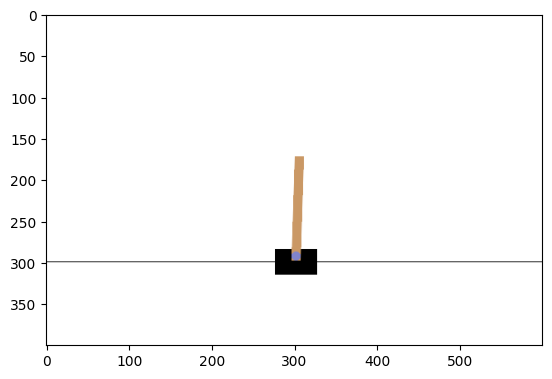

In [126]:
plt.imshow(env.render())
plt.show()

Total reward: 99.3


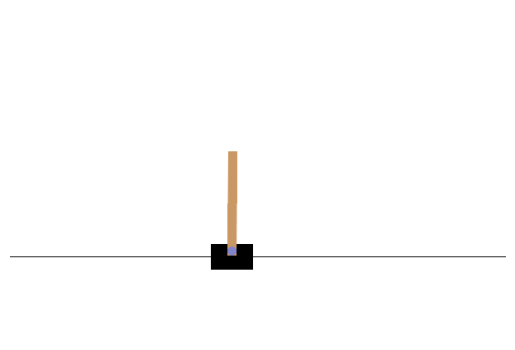

In [127]:
def policy(observation):
  action = np.random.choice([0, 1])
  LEFT, RIGHT = 0, 1
  cart_pos, cart_vel, pole_angle, pole_angular_vel = observation

  # TODO:
  if pole_angle + pole_angular_vel < 0:
    action = LEFT
  else:
    action = RIGHT

  return action

discount = 0.99
done = False
total_reward = 0


img = plt.imshow(env.render())
def render():
  rgb = env.render()
  if done:
    rgb[:, :, 1:] = rgb[:, :, 1:] / 2
  img.set_data(rgb)
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)


s, _ = env.reset()
for t in range(env._max_episode_steps):
#   print(t)
  action = policy(s)
  s, r, done, _, _ = env.step(action)
  render()
  total_reward += (discount**t) * r
  if done:
    break
print('Total reward: %.1f' % total_reward)

##  Question 1: Implement MPC + CEM
1. Write two functions from scratch:
   - cross_entropy_method(mean_probs, horizon, num_actions, sample_size, elite_frac, cem_iterations, evaluate_fn)
   - mpc_control(env, horizon, cem_iterations, sample_size, elite_frac, gamma)

2. cross_entropy_method(...)
   - Maintains or updates a probability distribution over action sequences (length H).
   - Samples multiple candidates, evaluates them, selects "elite" sequences, and refits the distribution.
   - Returns the best sequence found (and optionally the final distribution).

3. mpc_control(env, horizon, cem_iterations, sample_size, elite_frac, gamma)
   - On each environment step, calls the above CEM to get an action sequence of length H from the current state.
   - Executes the first action in the real env, obtains next state, continues until done.
   - If needed, you can "shift" or "reset" the distribution between steps.

Notes: In your solution, carefully implement how you evaluate each candidate action sequence from the current state



In [128]:
def cross_entropy_method(mean_probs, horizon, num_actions, sample_size, elite_frac, cem_iterations, evaluate_fn):
    """
    TODO: Implement the Cross-Entropy Method (CEM).

    Args:
        mean_probs (np.ndarray): shape (horizon, num_actions),
            the probability distribution over actions at each step.
        horizon (int): planning horizon (number of steps).
        num_actions (int): discrete action dimension (CartPole has 2).
        sample_size (int): how many candidate sequences to sample each iteration.
        elite_frac (float): fraction of top sequences to keep as "elite".
        cem_iterations (int): number of distribution-refinement iterations.
        evaluate_fn (callable): function(seq) -> returns a scalar cumulative reward for that action sequence.

    Returns:
        best_seq (np.ndarray): best action sequence found (shape: (horizon,))
        final_probs (np.ndarray): the final distribution (horizon x num_actions).
    """
    ### YOUR CODE HERE ###
    final_probs = mean_probs
    for i in range(cem_iterations):
        samples = np.array([np.random.choice(num_actions, sample_size, p=final_probs[t]) for t in range(horizon)]) # (horizon, sample_size)
        samples = samples.T # (sample_size, horizon)
        rewards = np.array([evaluate_fn(seq) for seq in samples]) # (sample_size,)
        elite_inds = rewards.argsort()[-int(sample_size * elite_frac):] # (elite_size,)
        elite_samples = samples[elite_inds] # (elite_size, horizon)
        
        elite_probs = np.zeros((horizon, num_actions))
        for t in range(horizon):
            for a in range(num_actions):
                elite_probs[t, a] = np.sum(elite_samples[:, t] == a) / elite_samples.shape[0]
        final_probs = elite_probs
        
    best_seq = elite_samples[0] # (horizon,)
    # print(f"best_seq: {best_seq}")
    # print(f"best reward: {rewards[elite_inds[0]]}")
    return best_seq, final_probs

In [129]:
def mpc_control(env, horizon=15, cem_iterations=4, sample_size=200, elite_frac=0.1, gamma=1.0):
    """
    TODO: Implement MPC with CEM for the CartPole environment.

    On each environment step:
      1) define an evaluate_fn that simulates a candidate sequence from the *current state* (or an approximation).
      2) call cross_entropy_method(...) to get the best sequence of length 'horizon'.
      3) execute the first action from 'best_seq'.
      4) repeat until done or max steps reached.

    Return:
        total_reward (float): total (possibly discounted) reward of this episode.
    """
    ### YOUR CODE HERE ###      
    def evaluate_fn(seq, temp_env=env):
        total_ret = 0.0
        discount_factor = 1.0
        for action in seq:
            # step
            s_next, rew, done_, _, _ = temp_env.step(action)
            total_ret += discount_factor * rew
            discount_factor *= gamma
            if done_:
                break
        return total_ret
      
    mean_probs = np.ones((horizon, env.action_space.n)) / env.action_space.n
    done = False
    s, _ = env.reset()
    total_reward = 0
    for t in range(env._max_episode_steps):
        seq, _ = cross_entropy_method(mean_probs, 
                                   horizon, 
                                   env.action_space.n, 
                                   sample_size, 
                                   elite_frac, 
                                   cem_iterations, 
                                   lambda seq: evaluate_fn(seq, copy.deepcopy(env)))
        action = seq[0]
        s, r, done, _, _ = env.step(action)
        # print(f"t: {t}, action: {action}, r: {r}")
        total_reward += (gamma**t) * r
        if done:
            break
    return total_reward
    
    

In [130]:
def run_mpc_cem_demo():
    """
    After implementing cross_entropy_method(...) and mpc_control(...),
    run multiple episodes to evaluate performance.
    """
    new_env = gym.make('CartPole-v1', render_mode='rgb_array')

    episodes = 5
    horizon = 15
    total_rewards = []
    for ep in range(episodes):
        ep_return = mpc_control(new_env, horizon=horizon, cem_iterations=4,
                                sample_size=200, elite_frac=0.1, gamma=1.0)
        total_rewards.append(ep_return)
        print(f"[MPC Episode {ep+1}] Return = {ep_return:.2f}")
    print("Average Return (MPC + CEM):", np.mean(total_rewards))

# Uncomment to test the MPC + CEM solution:
run_mpc_cem_demo()

[MPC Episode 1] Return = 378.00
[MPC Episode 2] Return = 336.00
[MPC Episode 3] Return = 342.00
[MPC Episode 4] Return = 500.00
[MPC Episode 5] Return = 171.00
Average Return (MPC + CEM): 345.4


## Zero-Order Policy Search With CEM
Now that you've seen how to use CEM for searching action sequences (MPC), let's re-use the same concept to search directly for a policy parameter vector. This is often called "Zero-Order Policy Search," because we do not require gradients of the policy. We only need to evaluate how good each parameter vector is.

In this question, you need to
1. Define a parametric policy for CartPole.
2. Reuse your CEM approach to search over w in $R^4$ (since CartPole state is 4D).
3. Evaluate each sampled w by running a full episode, gather total reward,
   pick elites, update distribution.
4. After some iterations, you get a final w. Evaluate that policy
   and report average return over multiple episodes.

Below is a skeleton with TODO for you to fill in.

In [145]:
def choose_action(w, obs):
    """
    A simple linear policy for CartPole:
      action = 1 if w dot obs > 0 else 0.
    w, obs: shape (4,)
    """
    ### YOUR CODE HERE ###
    action = 1 if np.dot(w, obs) > 0 else 0
    return action

In [146]:

def rollout_episode(env, w):
    """
    Run one full episode in 'env' using param 'w'.
    Return total (undiscounted) reward.
    """
    ### YOUR CODE HERE ###
    s, _ = env.reset()
    total_reward = 0
    done = False
    for t in range(env._max_episode_steps):
        action = choose_action(w, s)
        s, r, done, _, _ = env.step(action)
        total_reward += r
        if done:
            break
    return total_reward


In [150]:
def train_cem_policy(env, dim=4, cem_iterations=10, sample_size=50, elite_frac=0.2):
    """
    TODOs: Zero-Order Policy Search with CEM.
      1) Maintain param distribution (mean, std) in R^dim
      2) For iteration in [1..cem_iterations]:
         - sample 'sample_size' param vectors
         - evaluate each, get total reward
         - pick top 'elite_frac', update distribution
      3) Return best param or final mean
    """

    # Example init (feel free to change it)
    mean = np.zeros(dim)
    std = np.ones(dim)*2.0
    best_w = mean.copy()
    best_score = -1e9

    ### YOUR CODE HERE ###
    for _ in range(cem_iterations):
        samples = np.random.normal(mean, std, (sample_size, dim))
        rewards = np.array([rollout_episode(env, w) for w in samples])
        elite_inds = rewards.argsort()[-int(sample_size * elite_frac):]
        elite_samples = samples[elite_inds]
        mean = elite_samples.mean(axis=0)
        std = elite_samples.std(axis=0)
        best_score = rewards[elite_inds[-1]]
        best_w = elite_samples[-1]
    return best_w

In [151]:
def eval_policy(env, w, episodes=5):
    """
    TODOs: Evaluate policy param 'w' over multiple episodes
    and return average total reward.
    """
    ### YOUR CODE HERE ###
    total_rewards = [rollout_episode(env, w) for _ in range(episodes)]
    return np.mean(total_rewards)

In [152]:
def run_zero_order_cem_demo():
    """
    Demo for Problem 2: train & evaluate a linear policy with CEM.
    """
    env_zo = gym.make('CartPole-v1')
    env_zo._max_episode_steps = 200
    w_star = train_cem_policy(env_zo, dim=4, cem_iterations=10, sample_size=10, elite_frac=0.2)
    avg_ret = eval_policy(env_zo, w_star, episodes=5)
    print(f"\nFinal policy average return (Zero-Order Search) = {avg_ret:.2f}")


run_zero_order_cem_demo()


Final policy average return (Zero-Order Search) = 148.20
